In [4]:
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt

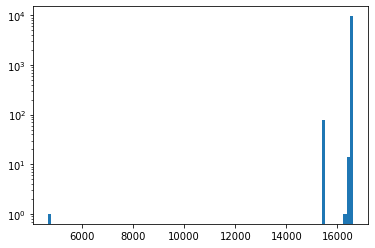

In [11]:
data = Fasta("data/15400-16700_sequence.fasta")
annotation = pd.read_csv("raw_data/annotation.csv")
length = []
for genome in data:
    length.append(len(str(genome)))
length = np.array(length)
plt.hist(length, log=True, bins=100)
plt.show()

In [24]:
kmer_freq = pd.read_csv("results/kmerFreq/kmer_freq.csv", index_col=0)
kmer_freq

,NC_029691.1,NC_017990.1,NC_030229.1,NC_026944.1,NC_027619.1,NC_027631.1,NC_027711.1,NC_028478.1,NC_029063.1,NC_029302.1,...,NC_029056.1,NC_035130.1,NC_035131.1,NC_034974.1,NC_055051.1,NC_055054.1,NC_055052.1,NC_055518.1,NC_055129.1,NC_055574.1
Kmer,,,,,,,,,,,,,,,,,,,,,
AAAAA,-0.554126,-0.014865,0.664298,4.995916,-0.718538,1.868979,4.175338,2.710264,-0.367634,24.271295,...,3.527116,-1.600222,-1.601256,-0.581681,6.053584,0.855074,-0.289945,4.551925,-0.248395,-0.160575
AAAAC,2.997830,0.439505,2.560441,0.699517,-0.539820,-0.035755,1.800767,1.450934,-0.043242,1.832617,...,0.114638,-0.371636,-0.371876,0.213568,1.841793,-0.041685,-0.126452,2.587581,2.565281,3.200395
AAAAG,0.925856,1.348244,2.560441,1.176894,-0.897257,-0.459029,-1.101485,3.465862,-0.367634,1.832617,...,2.162125,-1.600222,-1.601256,-0.581681,2.063466,-0.579741,-0.126452,1.496278,0.877075,0.097961
AAAAT,1.813845,-0.469234,0.190262,2.847716,-0.718538,-0.459029,1.009244,2.206532,-0.854221,1.667626,...,1.934626,-0.678782,-0.679221,-0.581681,2.285139,-0.221037,-0.780426,3.897144,2.283913,2.424787
AAACA,2.109841,1.802614,2.323423,0.699517,-0.897257,-1.093941,2.064609,1.199069,-0.692025,1.832617,...,0.569635,-0.064489,-0.064530,1.273900,3.171832,-0.938445,-0.780426,4.115404,0.595708,1.649178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGT,1.517848,0.212320,2.560441,1.176894,-0.361102,-1.093941,-0.046121,3.465862,-0.692025,-0.477247,...,1.479629,-0.371636,-0.371876,-0.316598,0.511753,-0.579741,-0.943919,0.186715,0.314340,1.132106
TTTTA,0.333863,-0.923604,0.664298,0.699517,-1.075975,-0.882304,-0.046121,1.199069,-1.016417,0.347704,...,0.342136,0.549805,0.550160,-0.581681,2.506813,-0.938445,-1.107413,0.623236,0.314340,0.097961
TTTTC,-0.258130,-0.469234,1.375352,2.609027,-0.539820,0.175882,-0.309962,1.450934,-0.205438,-0.477247,...,2.617122,-0.985929,-0.679221,-0.846765,2.506813,-0.400389,0.364028,-0.468067,-0.811130,-0.160575


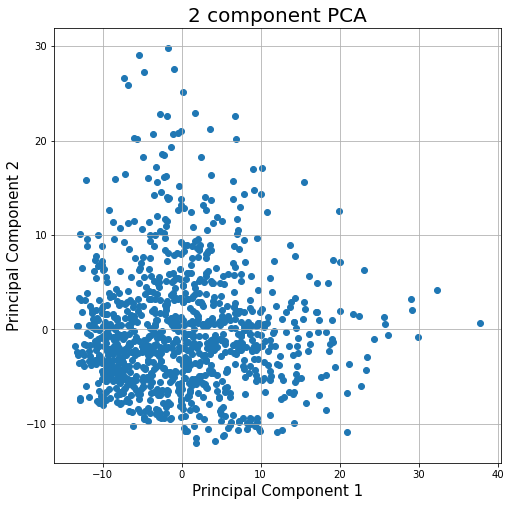

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(kmer_freq)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
# finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
# targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# colors = ['r', 'g', 'b']
# for target, color in zip(targets,colors):
    # indicesToKeep = finalDf['target'] == target
    # ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
    #            , finalDf.loc[indicesToKeep, 'principal component 2']
    #            , c = color
    #            , s = 50)
# ax.legend(targets)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()

In [29]:
principalComponents

PCA(n_components=2)

In [5]:
def float2bin(num:str):
    out = ['0','.']
    while type(num) != int and len(out)<8:
        if num*2>=1:
            num -= 1
            out.append('1')
        else:
            out.append('0')
        print(type(num))
    return "".join(out)
float2bin(0.75)

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


'0.100000'